In [2]:
import cv2
import numpy as np
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Define video function
from moviepy.editor import VideoFileClip
from IPython.display import HTML
def create_video( pipeline_in, input_video, output_video ):
    # Process video
    video = VideoFileClip( input_video )
    video_processed = video.fl_image( pipeline_in )
    %time video_processed.write_videofile( output_video, audio=False )
    
# Define handy side by side plot function
def plot( image1, image2, title2):
    # Plot
    f, (ax1, ax2) = plt.subplots(1, 2, figsize=(24, 9))
    f.tight_layout()
    ax1.imshow(image1, cmap='gray')
    ax1.set_title('Original', fontsize=30)
    ax1.axis('off')
    ax2.imshow(image2, cmap='gray')
    ax2.axis('off')
    ax2.set_title(title2, fontsize=30)
    plt.subplots_adjust(left=0., right=1, top=0.9, bottom=0.)
    return ax2



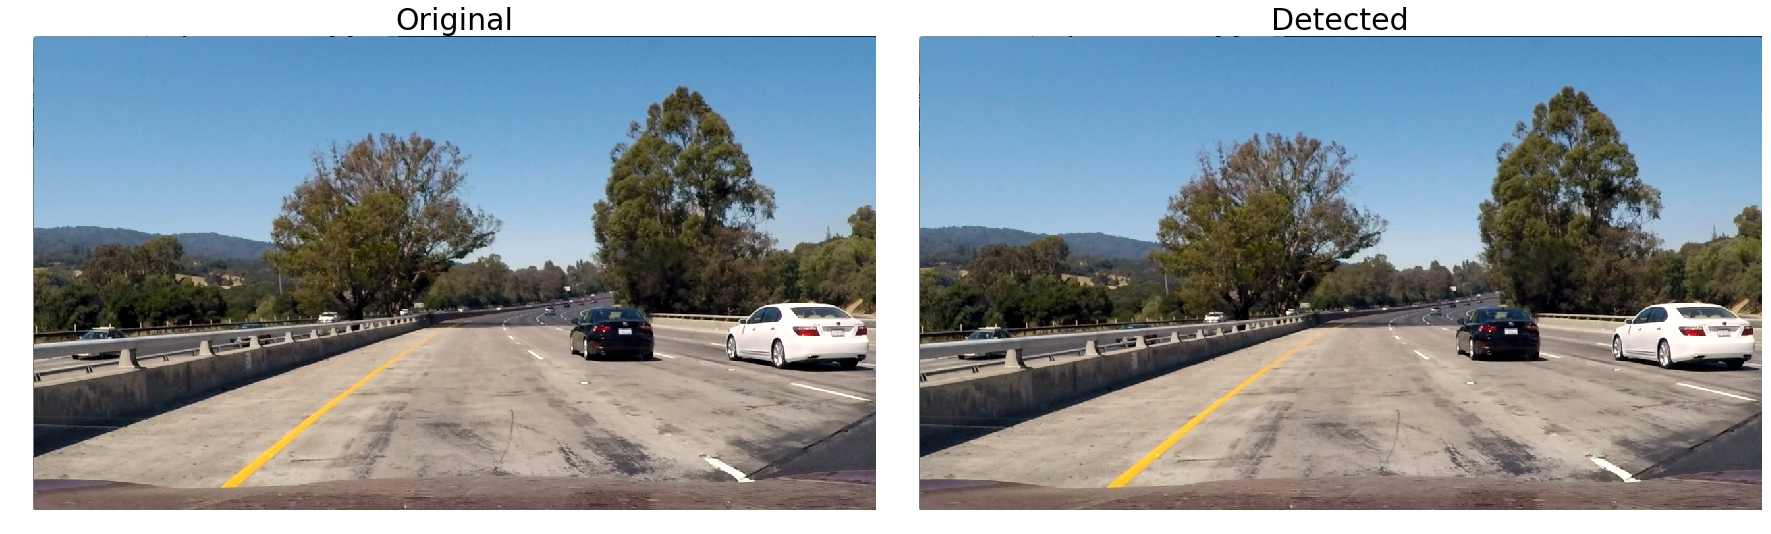

In [4]:
# Test images
images = glob.glob('test_images/*.jpg')
for filename in images:
    
    # Plot side by side
    image = cv2.imread( filename )
    image = cv2.cvtColor( image, cv2.COLOR_BGR2RGB )
    plot( image, image, "Detected" )
    break
    

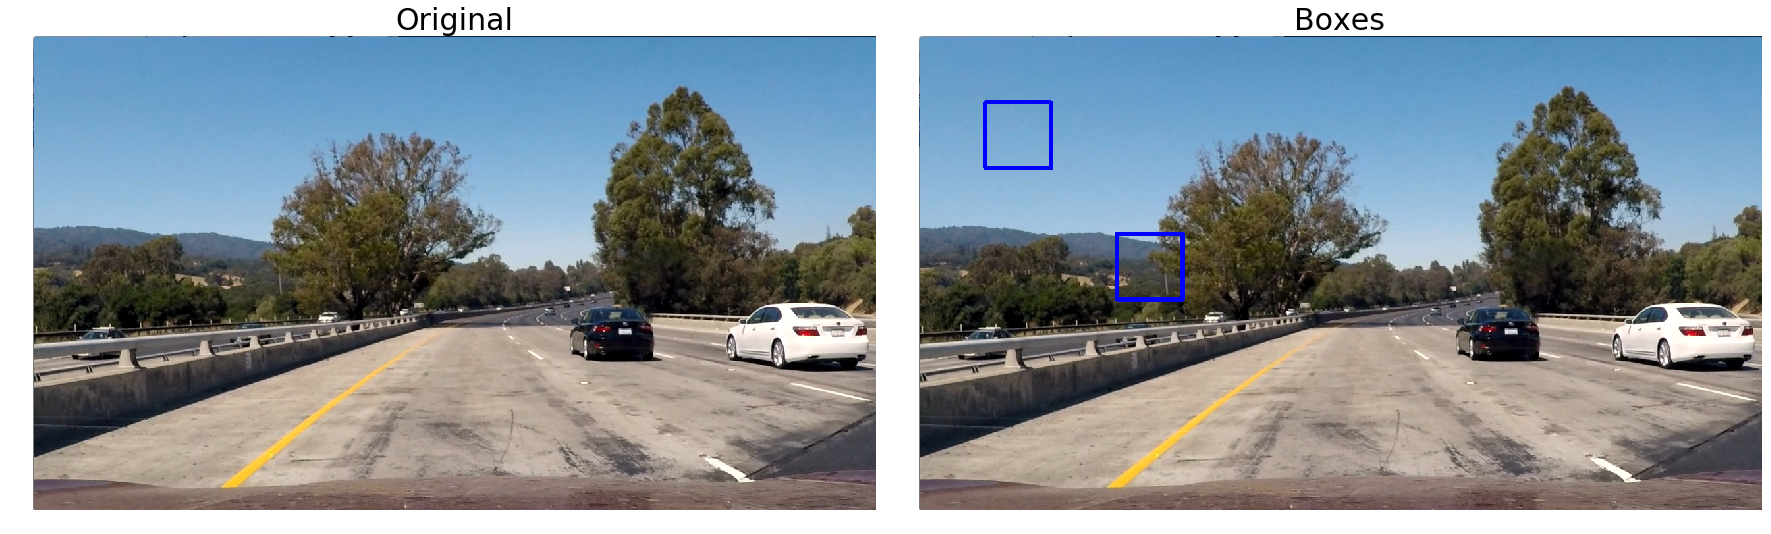

In [5]:
# Load image
image = mpimg.imread('test_images/test1.jpg')

# Define draw boxes function
def draw_boxes(image, boxes, colour=(0, 0, 255), thickness=6):
    # Copy image
    draw_image = np.copy(image)
    
    # Draw each bounding box
    for box in boxes:
        cv2.rectangle(draw_image, box[0], box[1], colour, thickness)
    return draw_image

# Test
boxes = [((100, 100), (200, 200)), ((300, 300), (400, 400))]
result = draw_boxes(image, boxes)
plot(image, result, "Boxes")


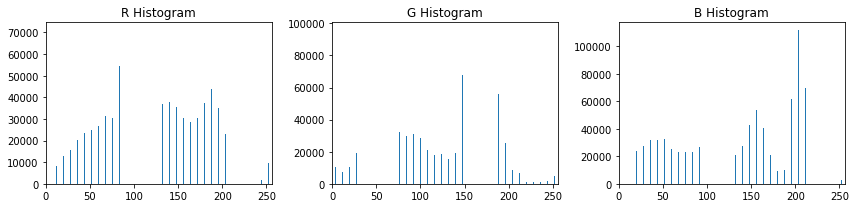

In [6]:
# Load image
image = mpimg.imread('test_images/test1.jpg')

# Define a function to compute color histogram features  
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the RGB channels separately
    rhist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    ghist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    bhist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    
    # Generating bin centers
    bin_edges = rhist[1]
    bin_centers = (bin_edges[1:]  + bin_edges[0:len(bin_edges)-1])/2
    
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((rhist[0], ghist[0], bhist[0]))
    
    # Return the individual histograms, bin_centers and feature vector
    return rhist, ghist, bhist, bin_centers, hist_features

# Run
rh, gh, bh, bincen, feature_vec = color_hist(image, nbins=32, bins_range=(0, 256))

# Plot
if rh is not None:
    fig = plt.figure(figsize=(12,3))
    plt.subplot(131)
    plt.bar(bincen, rh[0])
    plt.xlim(0, 256)
    plt.title('R Histogram')
    plt.subplot(132)
    plt.bar(bincen, gh[0])
    plt.xlim(0, 256)
    plt.title('G Histogram')
    plt.subplot(133)
    plt.bar(bincen, bh[0])
    plt.xlim(0, 256)
    plt.title('B Histogram')
    fig.tight_layout()


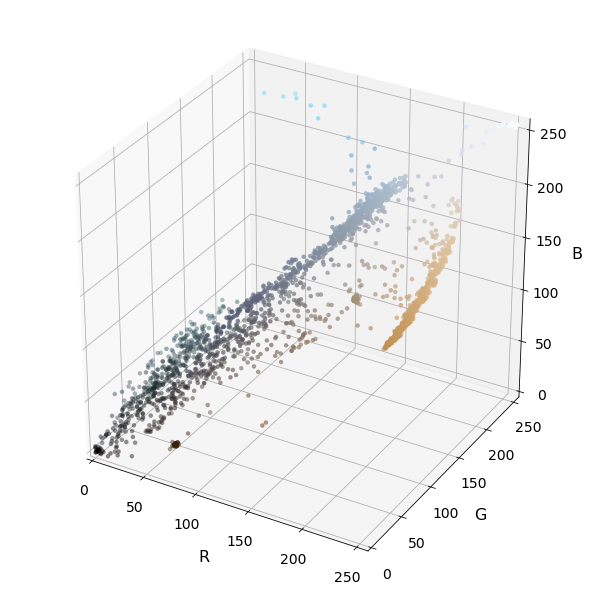

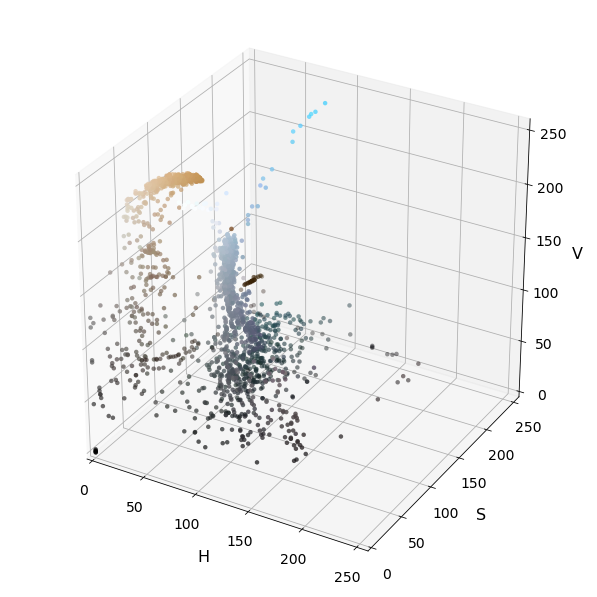

In [7]:
from mpl_toolkits.mplot3d import Axes3D

def plot3d(pixels, colors_rgb, axis_labels=list("RGB"), axis_limits=[(0, 255), (0, 255), (0, 255)]):

    # Create figure and 3D axes
    fig = plt.figure(figsize=(8, 8))
    ax = Axes3D(fig)

    # Set axis limits
    ax.set_xlim(*axis_limits[0])
    ax.set_ylim(*axis_limits[1])
    ax.set_zlim(*axis_limits[2])

    # Set axis labels and sizes
    ax.tick_params(axis='both', which='major', labelsize=14, pad=8)
    ax.set_xlabel(axis_labels[0], fontsize=16, labelpad=16)
    ax.set_ylabel(axis_labels[1], fontsize=16, labelpad=16)
    ax.set_zlabel(axis_labels[2], fontsize=16, labelpad=16)

    # Plot pixel values with colors given in colors_rgb
    ax.scatter(
        pixels[:, :, 0].ravel(),
        pixels[:, :, 1].ravel(),
        pixels[:, :, 2].ravel(),
        c=colors_rgb.reshape((-1, 3)), edgecolors='none')

    return ax  # return Axes3D object for further manipulation

# Load image
image = mpimg.imread('test_images/test1.jpg')

# Select a small fraction of pixels to plot by subsampling it
scale = max(image.shape[0], image.shape[1], 64) / 64  # at most 64 rows and columns
img_small = cv2.resize(image, (np.int(image.shape[1] / scale), np.int(image.shape[0] / scale)), interpolation=cv2.INTER_NEAREST)

# Convert subsampled image to desired color space(s)
img_small_RGB = cv2.cvtColor(img_small, cv2.COLOR_BGR2RGB)  # OpenCV uses BGR, matplotlib likes RGB
img_small_HSV = cv2.cvtColor(img_small, cv2.COLOR_BGR2HSV)
img_small_rgb = img_small_RGB / 255.  # scaled to [0, 1], only for plotting

# Plot
plot3d(img_small_RGB, img_small_rgb)
plt.show()

# Plot
plot3d(img_small_HSV, img_small_rgb, axis_labels=list("HSV"))
plt.show()

In [7]:
# Define pipeline 
def pipeline( image ):
    return image

In [8]:
# Create video
create_video( pipeline, "test_video.mp4", "test_output.mp4" )

# Show video
HTML("""<video width="960" height="540" controls><source src="{0}"></video>""".format( "test_output.mp4" ))

[MoviePy] >>>> Building video test_output.mp4
[MoviePy] Writing video test_output.mp4


 97%|█████████▋| 38/39 [00:00<00:00, 81.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_output.mp4 

CPU times: user 83.1 ms, sys: 90.7 ms, total: 174 ms
Wall time: 1.99 s
